## Example: Underdetermined linear system
#### Section 4.1 of the paper

$$
\boldsymbol{\mathcal{V}} \in \mathbb{R}^3, \boldsymbol{\mathcal{Y}} \in \mathbb{R}^2, \mathbf{F}: \mathbb{R}^3 \to \mathbb{R}^2 \ .
$$

$$ \textrm{Matrix representation of the linear system} \ :
    \boldsymbol{y} = 
    \begin{bmatrix}
        y_1 \\ y_2 
    \end{bmatrix}
    =
    \begin{bmatrix}
        \pi & e & 0\\
          0 & e & \pi
    \end{bmatrix}
    \cdot 
    \begin{bmatrix}
        v_1 \\ v_2 \\ v_3 
    \end{bmatrix}
    = \mathbf{F}\,\boldsymbol{v}.
$$

$$
\textrm{Non-identifiable manifold of $\boldsymbol{\mathcal{V}}$} \ :    \textrm{Ker}(\mathbf{F}) \subset \mathbb{R} \approx c^*[0.5475278,-0.6327928, 0.5475278]^T .
$$

In [1]:
# Note: Please initiate Jupyter Lab where this script is located
# Note: re-start the python kernel if some attribute of a class is not identified
# Note: there is an abuse of notation of x (X) and v. The x (X) in the code mostly means the v in the paper
# Note: the hyperparameters have been adjusted for faster execution within JupyterLab. 
#        For more precise results and improved efficiency, we recommend running the code locally with appropriately fine-tuned hyperparameters

import torch
import os
import math
import numpy as np
import sys
import time
import copy
from matplotlib import pyplot as plt
%matplotlib ipympl
from PIL import Image
from pdf2image import convert_from_path
from Tools.Data_generation import * # Data generation
from Tools.DNN_tools import *       # Common tools in DNN modeling
from Tools.Training_tools import *  # Main trainer class of the inVAErt network and the training/testing algorithm
from Tools.plotter import *         # Common plotting tools 

### Basic setup: device, precision and folder creation 

For each case, remember to change the case label

In [2]:
# Basic setup
#--------------------------------------------------------------------------------------#
# determine if to use GPU, GPU is faster with large mini-batch
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# set tensor type to double
torch.set_default_tensor_type(torch.DoubleTensor)

# path for saving the synthetic dataset
os.makedirs('Dataset/', exist_ok = True)   

# path for saving the trained neural network model 
os.makedirs('Model_save/', exist_ok = True)

# case label
prefix = 'simple_linear'
#--------------------------------------------------------------------------------------#


### Data generation, scaling and training/testing dataset split

For any case, we only need to define the dataset $\mathbf{X}$ and $\mathbf{Y}$. They can be synthetic data or solutions of ODE/PDEs.
$\mathbf{X}$ is the input tensor containing the $\boldsymbol{v}$ samples plus the auxiliary data $\mathcal{D}_{\boldsymbol{v}} \ $, if needed. $\mathbf{Y}$ is the output tensor containing the $\boldsymbol{y}$ samples.

In this example, we define uniform random samples of $\boldsymbol{v} \sim \mathcal{U}([0,5]^3)$ and forward the linear system 10000 times to gather the training data.

In [3]:
# Data generation
# X: input tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(V) or dim(V) + dim(D_v), i.e. if auxiliary data is used, see Section 2.1
# Y: output tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(Y)
#-------------------------------------------------------------------------#
# If True, save the generated data, If False, load the generated data. 
Saving      = True                     

# If True, scale the data, use z-std method (c.f. Appendix of the paper)
Scaling     = True

# Define box bounds
lower_bounds = [0, 0, 0]    #  lower bounds of the 3D domain
upper_bounds = [5, 5, 5]    #  higher bounds of the 3D domain

# Define datasize
Sample_size  = 10000        # how many samples generated

# generate or load the data
if Saving == True:
	# call data generator function and save the data
	X,Y =  Data_simple_linear(Sample_size, lower_bounds, upper_bounds, Saving)
    
    # load the generated data from file
else:
	X   = np.loadtxt('Dataset/' + prefix + '_X.csv', delimiter = ',', ndmin=2) 
	Y   = np.loadtxt('Dataset/' + prefix + '_Y.csv', delimiter = ',', ndmin=2) #ndmin = 2 means: always keep array dimension = 2

# backup for later plotting
Y_plot = copy.deepcopy(Y)
V_plot = copy.deepcopy(X)

# Data-normalization if needed
if Scaling == True:
    # call z-standardization 
	scaler = Zscaling()
	X, muX, stdX = scaler.z_std(X) # apply transformation, record the mu and std
	Y, muY, stdY = scaler.z_std(Y) # apply transformation, record the mu and std
    
# convert to pytorch tensors from numpy array
X = torch.from_numpy(X).to(device)
Y = torch.from_numpy(Y).to(device)

# Training-Testing-Dataset-Split
T_portion = 0.75 # 75% for training, the rest for testing
train_tensor, train_truth_tensor, test_tensor, test_truth_tensor = \
									TT_split(Sample_size, T_portion, X, Y)

print('data-generation is done...')
#-------------------------------------------------------------------------#

Data generation: 2000/10000
Data generation: 4000/10000
Data generation: 6000/10000
Data generation: 8000/10000
Data generation: 10000/10000
data-generation is done...


### Define hyperparamters, initiate trainer class and define each component of the inVAErt network

For the current setup, we define the emulator $\mathscr{N}_e \ $, the Real-NVP based normalizing flow model $\mathscr{N}_f$ and the variational decoder (VAE + decoder) $\mathscr{N}_v$ + $\mathscr{N}_d$ as three separate modules and train them independently. This allows us always use the exact label instead of network predictions. However, for stochastic extension of our inVAErt network, we need to trained them altogether. For more details, please see the appendix and Section 2.4 of the paper.

In [4]:
# Define hyperparameters, initiate trainer and define models 
#-------------------------------------------------------------------------------#
# init folder
folder_name = 'Model_save/'+ prefix 
os.makedirs(folder_name, exist_ok = True) # warning: be careful the overwrite here
# if scaled, save the scaling constants
if Scaling == True:
    scaler.save_scaling_constants(folder_name, muX, muY, stdX, stdY)

# Define hyperparameters, see, e.g. appendix of the paper
# Note: grid search for more optimal parameters TBD
para_dim    =   X.shape[1]              # dim(V). In this case, we do not have auxillary data
nB          =   [128,128,128]            # mini-batch size of N_e, N_f, N_v+N_d
learning_rate = [1e-2, 1e-2, 1e-2]      # initial learning rate for N_e, N_f, N_v+N_d
encoder_para  = [3,2,'identity']        # num_of_neuron, num_of_layer, type_of_act fun for emulator N_e
nf_para       = [6,4,4, False]          # num_of_neuron, num_of_layer_of_each_block, num_of_affine_coupling_blocks, \
                                        # if_using_batch_norm for Real-NVP normalizing flow model N_f
vae_para      = [8,4,'silu']            # num_of_neuron, num_of_layer, type_of_act fun for VAE N_v
decoder_para  = [8,4,'silu']          # num_of_neuron, num_of_layer, type_of_act fun for decoder N_d
penalty       = [1, 40]                 # penalty for KL div and decoder reconstruction loss, note: the encoder re-constraint loss L_r is not used here
lr_min        = [1e-4, 1e-4, 1e-4]      # minimal learning rate of N_e, N_f, N_v+N_d
decay         = [0.98, 0.98, 0.992]     # learning rate decay rate of N_e, N_f, N_v+N_d
weight_decay  = [0,0,0]              # L2 regularization of N_e, N_f, N_v+N_d    
#--------------------------------------------------------------------------------#

# Initiate trainer class
Trainer = Training(X, Y, para_dim, train_tensor = train_tensor, train_truth_tensor = train_truth_tensor,\
									 test_tensor = test_tensor, test_truth_tensor = test_truth_tensor)

# Define models, i.e. N_e, N_f, N_v+N_d
Encoder_model, NF_model, Decoder_model = Trainer.Define_Models(device, encoder_para, nf_para, vae_para, decoder_para)

Number of trainable para for encoder is:20
Number of trainable para for NF sampler is:824
Number of trainable para for VAE+decoder is:397


### Training and testing step of the emulator $\mathscr{N}_e$

Waiting time: < 30 seconds

In [5]:
#--------------------------------------------start to train each component of inVAErt--------------------------------------------------#
%matplotlib agg
# Training and testing step of the encoder, i.e. the emulator N_e
Trainer.Encoder_train_test(folder_name, Encoder_model, lr_min[0], learning_rate[0], decay[0], nB[0])
%matplotlib inline



---------------Start to train the encoder-----------------
Total number of epoches for training encoder is:227
Encoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, forward loss: 1.886e-01 , forward acc : 80.987009% , current lr: 1.000e-02
Testing: forward loss: 2.305e-03 , forward acc : 99.771872%
Training: Epoch: 200, forward loss: 4.934e-32 , forward acc : 100.000000% , current lr: 1.759e-04
Testing: forward loss: 4.740e-32 , forward acc : 100.000000%


In [6]:
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

# plotting specs
fs = 24
plt.rc('font',  family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text',  usetex=True)

### Verification of the emulator $\mathscr{N}_e$ 

We pick uniform random samples of $\boldsymbol{v}$ not belong to the training dataset and forward the trained emulator $\mathscr{N}_e \ $. From the following plot, we see the emulator prediction (NN) matches well with the truth (Trivial in the current case).

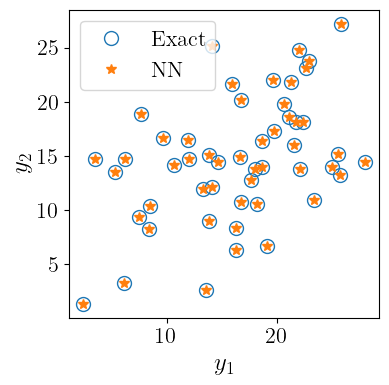

In [7]:
np.random.seed(65434344)    # pick a seed not belong to the training dataset, which is zero, you can play with this number
test_size      = 50        # how many samples of v to be drawn
x_star         = torch.from_numpy(np.random.uniform(low=lower_bounds, high=upper_bounds, size=(test_size,3))) # draw random samples of v

# compute the truth
coef       = torch.tensor( [[math.pi, math.exp(1), 0.0],[0.0, math.exp(1), math.pi]] ) # coefficients of the matrix
y_truth    = torch.matmul(coef, torch.transpose(x_star, 0, 1)).T.detach().numpy() 

# if using scaling during training, 
if Scaling == True:
	x_star = scaler.scale_it_forward(x_star, muX, stdX)

# Forward the trained emulator N_e
Encoder_model.eval()
with torch.no_grad():
	y_star = Encoder_model(x_star).detach().numpy()

# scale it back if scaled before
if Scaling == True:
	y_star = scaler.scale_it_back(y_star,muY,stdY)

plt.figure(figsize=(4, 4))
plt.plot(y_truth[:,0], y_truth[:,1], 'o', markersize=10, markerfacecolor='none', label='Exact')
plt.plot(y_star[:,0], y_star[:,1], '*', markersize=7, label = 'NN')
plt.legend(fontsize=fs-8)
plt.xlabel('$y_1$', fontsize=fs-6)
plt.ylabel('$y_2$', fontsize=fs-6)
plt.tick_params(labelsize=fs-8)

### Training and testing step of the Real-NVP based normalizing flow model $\mathscr{N}_f$

Waiting time: < 1 min

In [8]:
# training and testing step of the Real-NVP based NF model
%matplotlib agg
Trainer.NF_train_test(folder_name, NF_model, lr_min[1], learning_rate[1], decay[1], nB[1])
%matplotlib inline



---------------Start to train the Real NVP-----------------
Total number of epoches for training NF is:227
NF: Total num of training batches:59, testing batches:20
Training: Epoch: 0, likelihood loss: 2.794e+00 , current lr: 1.000e-02
Testing: likelihood loss: 2.751e+00
Training: Epoch: 200, likelihood loss: 2.670e+00 , current lr: 1.759e-04
Testing: likelihood loss: 2.676e+00


### Verification of the Real-NVP based NF model $\mathscr{N}_f$ 

We pick random samples of $\boldsymbol{z}$ from the base distribution of the NF model, i.e. standard normal distribution, and apply the trained NF transformations:  $\boldsymbol{z} \to \boldsymbol{y}$. The learned distributions as well as the correlation of $y_1$ and $y_2$ (NN) match well with the distributions and correlation from the true data (Exact). Again, due to the simplicity of this problem, this task is still trivial.

Text(0.5, 1.0, '$y_1$-$y_2$ correlation')

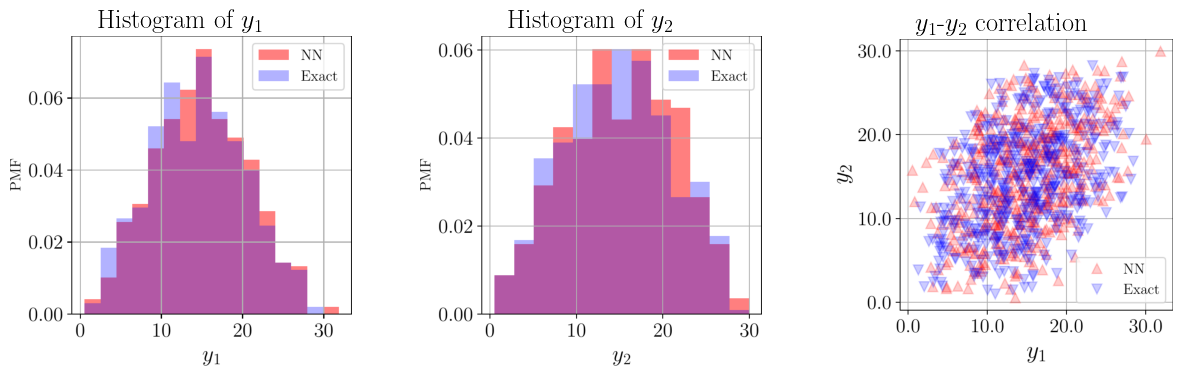

In [9]:
NF_Sample_size = 500 # How many samples needed

# sample z from N(0,1) and transform back to y
Y_hat_samples = NF_model.sampling(NF_Sample_size, NF_model, seed_control= 232542) # pick a random seed here

# Scaling back if needed
if Scaling == True:
    Y_hat_samples = scaler.scale_it_back(Y_hat_samples, muY, stdY)

# where to save the figures
path     = folder_name + '/figures/NF'

#Save histogram and scatter correlation plots
%matplotlib agg
hist_plot(path, 'y1', Y_hat_samples[:,0], '$y_1$', exact=Y_plot[:NF_Sample_size,0]) # histogram comparison for y1
hist_plot(path, 'y2', Y_hat_samples[:,1], '$y_2$', exact=Y_plot[:NF_Sample_size,1]) # histogram comparison for y2
scatter2D_plot(path, 'y1-y2-corr', Y_hat_samples[:,[0,1]], '$y_1$', '$y_2$', exact=Y_plot[:NF_Sample_size,[0,1]]) # correlation scatter plot
%matplotlib inline

# show figures
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
im1 = convert_from_path(path + '/y1.pdf')
plt.imshow(im1[0])
plt.axis('off')
plt.title('Histogram of $y_1$', fontsize = fs-5)

plt.subplot(1, 3, 2)
im2 = convert_from_path(path + '/y2.pdf')
plt.imshow(im2[0])
plt.axis('off')
plt.title('Histogram of $y_2$', fontsize = fs-5)

plt.subplot(1, 3, 3)
im3 = convert_from_path(path + '/y1-y2-corr.pdf')
plt.imshow(im3[0])
plt.axis('off')
plt.title('$y_1$-$y_2$ correlation', fontsize = fs-5)

### Training and testing step of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$

Waiting time: < 1 min


In [10]:
# training and testing step of the VAE and decoder
%matplotlib agg
Trainer.Decoder_train_test(folder_name, Decoder_model, lr_min[2], learning_rate[2], decay[2], nB[2], penalty, l2_decay = weight_decay[2])
%matplotlib inline



---------------Start to train the variational decoder-----------------
Total number of epoches for training variational decoder is:573
VAEDecoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, inversion loss: 5.636e-01 , inversion acc : 43.199339% , KL : 4.459e-01 , current lr: 1.000e-02
Testing: inversion loss: 7.286e-02 , inversion acc : 92.859091% , KL : 1.758e+00
Training: Epoch: 200, inversion loss: 1.300e-02 , inversion acc : 98.687298% , KL : 1.329e+00 , current lr: 2.006e-03
Testing: inversion loss: 2.047e-03 , inversion acc : 99.799289% , KL : 1.336e+00
Training: Epoch: 400, inversion loss: 1.227e-02 , inversion acc : 98.762392% , KL : 1.318e+00 , current lr: 4.024e-04
Testing: inversion loss: 1.427e-03 , inversion acc : 99.860188% , KL : 1.334e+00


### Verification of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$   

#### Task1: non-identifiability analysis

In this task, we fix a $\boldsymbol{y}^*$ sampled from the previously trained NF model $\mathscr{N}_f$ and sample $N$ latent variables $w$ from the latent space, which is the standard Gaussian distribution. This will give us $N$ values of $\tilde{\boldsymbol{y}}^* = [\boldsymbol{y}^*, w]^T$ that correpond to the same $\boldsymbol{y}^*$ and different values of $w \sim \mathcal{N}(0,1)$. 

Then, we apply the trained decoder $\mathscr{N}_d$ for model inversion, which predicts the system inputs $\widehat{\boldsymbol{v}}$ that should live in the null space of the forward map $\mathbf{F}$, i.e. $\widehat{\boldsymbol{v}} \in \textrm{Ker}(\mathbf{F})$.

In [11]:
# sample one y^* from the trained NF 
y_fix  = NF_model.sampling(1, NF_model, seed_control= 83419) 

# how many latent variable w will be drawn from the latent space
W_size = 50 

# Decoding with trained N_d
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 1243430 , Task = 'FixY', y_given = y_fix)

# Scaling back if needed
if Scaling == True:
	X_samples           = scaler.scale_it_back(X_samples,muX,stdX)
	y_fix               = scaler.scale_it_back(y_fix, muY, stdY)

First, we plot the sample trajectory and verify $\widehat{\boldsymbol{v}} \in \textrm{Ker}(\mathbf{F})$ by performing a simple line-fit algorithm to the inverted samples $\widehat{\boldsymbol{v}}$.

Exact kernel vector:[ 0.54752775 -0.6327928   0.54752775]
----------------------------
line fit as:[-0.54763003  0.63098016 -0.54951378]
IP with kernel as:-0.9999963797935687
----------------------------


Vector([-0.54763003,  0.63098016, -0.54951378])

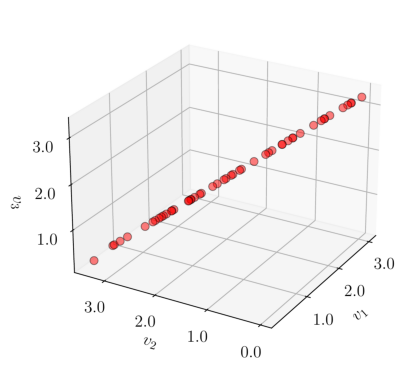

In [12]:
# scatter-plot of v_1,v_2 and v_3
path_inv     = folder_name + '/figures/Inversion'
elev         = 25   # view point argument 1
azim         = -150 # view point argument 2

# save scatter plot
%matplotlib agg
scatter3D_plot(path_inv, 'Fix-1-y', X_samples, ['$v_1$','$v_2$','$v_3$'], elev, azim)
%matplotlib inline

# show scatter plot
plt.figure(figsize=(5, 5))
im_fix1y = convert_from_path(path_inv + '/Fix-1-y.pdf')
plt.imshow(im_fix1y[0])
plt.axis('off')

# perform line-fit and calculate the inner product (IP) with respect to the exact null space vector
line_plane_check(X_samples, arg='line') # this code is located at DNN_tools.py

We find the inverted samples of $\widehat{\boldsymbol{v}}$ form a 1-D structure with the (fitted) directional vector close to $\textrm{Ker}(\mathbf{F})$. This can also be checked by the inner product test (IP), which we have $\text{IP} \approx \pm 1$.

Note that if $\mathbf{F} \boldsymbol{v} = \boldsymbol{y}^*$, then $\mathbf{F}\big( \boldsymbol{v} +  \textrm{Ker}(\mathbf{F}) \big)= \boldsymbol{y}^*$. This expectation matches our implentation and results of $\mathscr{N}_d$.

Now, what if we fix three different $\boldsymbol{y}^*$'s from $\mathscr{N}_f$ and perform the same task?

Exact kernel vector:[ 0.54752775 -0.6327928   0.54752775]
----------------------------
line fit as:[-0.54798678  0.63326634 -0.54652011]
IP with kernel as:-0.9999992748581004
----------------------------
Exact kernel vector:[ 0.54752775 -0.6327928   0.54752775]
----------------------------
line fit as:[-0.55002164  0.63000753 -0.54823964]
IP with kernel as:-0.9999927580101446
----------------------------
Exact kernel vector:[ 0.54752775 -0.6327928   0.54752775]
----------------------------
line fit as:[-0.54087786  0.63685761 -0.54942109]
IP with kernel as:-0.9999678357359423
----------------------------


(-0.5, 1031.5, 929.5, -0.5)

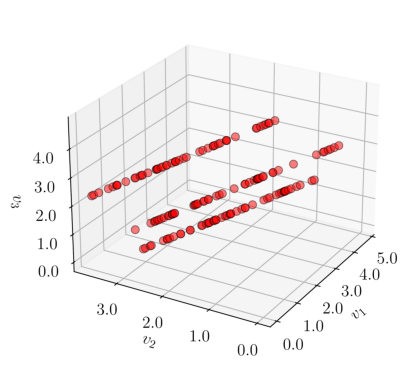

In [13]:
for i in range(3):
	y_fix  = NF_model.sampling(1, NF_model,seed_control= i+744352) # pick a random seed here
	
    # go tho trained decoder
	X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 553546+i , Task = 'FixY', y_given = y_fix)
	
	# apply scaling if needed
	if Scaling == True:
		X_samples = scaler.scale_it_back(X_samples,muX,stdX)

	# inner product check with respect to the true kernel vector
	line_plane_check(X_samples, arg='line') 

	# cat results
	if i == 0:
		X_plot = X_samples
	else:
		X_plot = np.concatenate((X_plot, X_samples), axis=0)

# save scatter plot
%matplotlib agg
scatter3D_plot(path_inv, 'Fix-3-y', X_plot, ['$v_1$','$v_2$','$v_3$'], elev, azim)
%matplotlib inline

# show scatter plot
plt.figure(figsize=(5, 5))
im_fix3y = convert_from_path(path_inv + '/Fix-3-y.pdf')
plt.imshow(im_fix3y[0])
plt.axis('off')

This time, each of the three fixed $\boldsymbol{y}^*$'s results in a 1-D trajectory closely aligning with the kernel direction $\textrm{Ker}(\mathbf{F})$, which matches our expectation.

#### Task2: Fix the latent variable $w$ and sample $\boldsymbol{y}$ from the trained $\mathscr{N}_f$

In this task, we fix a $w^*$ sampled from the latent space, i.e $\mathcal{N}(0,1)$, and sample the system output $\boldsymbol{y}$ from the previously trained NF model $\mathscr{N}_f$.
This will give us $N$ values of $\tilde{\boldsymbol{y}}^* = [\boldsymbol{y}, w^*]^T$ that correpond to the same $w^*$ and different values of $\boldsymbol{y}$ from $\mathscr{N}_f$.  As opposed to task1, after decoding, we expect to find the manifold embedded in the input $\boldsymbol{\mathcal{V}}$ which leads to the most sensitive change in the output space $\boldsymbol{\mathcal{Y}}$.

For the current linear system, this manifold to be found should be ideally orthogonal to the null space of $\boldsymbol{\mathcal{V}}$, i.e. we are looking for $\textrm{Ker}(\mathbf{F})^{\perp}$. Since $\textrm{Ker}(\mathbf{F})$ is a 1D line, then $\textrm{Ker}(\mathbf{F})^{\perp}$ is a 2D plane orthogonal to $\textrm{Ker}(\mathbf{F})$.

Exact kernel vector:[ 0.54752775 -0.6327928   0.54752775]
----------------------------
plane fit as:[ 0.56581614 -0.6372265   0.52325375]
IP with kernel as:0.9995283250397153
----------------------------


Vector([ 0.56581614, -0.6372265 ,  0.52325375])

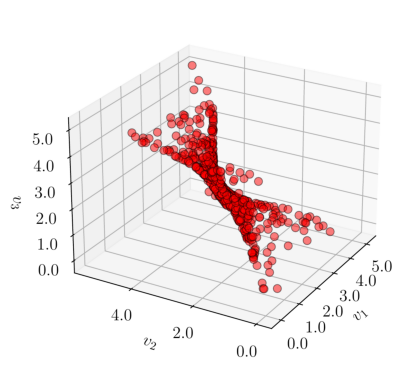

In [14]:
# how many y will be drawn from the trained NF
Y_size = 500

# sample y from the trained NF
y_samples  = NF_model.sampling(Y_size, NF_model, seed_control= 2244332) # pick a random seed here

# invert the system
X_samples = Decoder_model.inversion_sampling(Decoder_model, Y_size, seed_control = 413343, Task = 'FixW',  y_given = torch.from_numpy(y_samples))

# scaling back if needed
if Scaling == True:
	X_samples = scaler.scale_it_back(X_samples,muX,stdX)

# save scatter plot
%matplotlib agg
scatter3D_plot(path_inv, 'Fix-1-w', X_samples, ['$v_1$','$v_2$','$v_3$'], elev, azim)
%matplotlib inline

# show scatter plot
plt.figure(figsize=(5, 5))
im_fix1w = convert_from_path(path_inv + '/Fix-1-w.pdf')
plt.imshow(im_fix1w[0])
plt.axis('off')

# perform plane-fit and calculate the inner product (IP) between the exact null space vector and the plane-normal vector
line_plane_check(X_samples, arg='plane') # this code is located at DNN_tools.py

# # interactive mode
# %matplotlib ipympl
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_samples[:,0], X_samples[:,1], X_samples[:,2])
# plt.show()

The fitted plane of this task is not exactly a straight plane, while its normal direction is close to the null space $\textrm{Ker}(\mathbf{F})$. We have the following observations and conjectures:

* We can have the straight 2D plane learned if the decoder network $\mathscr{N}_d$ is set to be pure linear (not shown here).
* Most "curved" parts of the learned manifold are around the box boundaries.
* Fine-tuning hyper-parameters would not make it better (At least we did not figure it out).
* Allowing training data repetition may lead to better results (each $\boldsymbol{y}$ can be seen multiple times with different $w \sim \mathcal{N}(0,1)$ during training).
* To prepare training data, we may try the sobol sampling method.

#### Task3: Fix nothing, sample $\boldsymbol{w}$ and $\boldsymbol{y}$ altogether 

In this task, we sample $w$ from $\mathcal{N}(0,1)$ and sample $\boldsymbol{y}$ from the trained $\mathscr{N}_f$ at the same time. Since there is no constraint, we are expecting to get every possible input values. In another words, if sampled enough, the distribution of the inverse predictions $\widehat{\boldsymbol{v}}$ should match the given distribution during training data preparation, i.e. $\mathcal{U}([0,5]^3)$.

Text(0.5, 1.0, 'Scatter plot of $\\widehat{\\boldsymbol{v}}$')

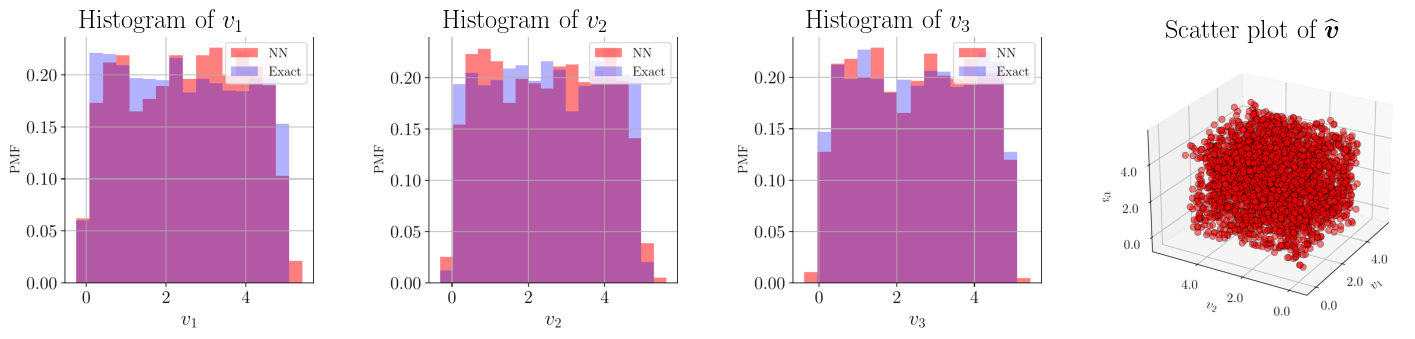

In [15]:
# how many samples we need
ytilde_sample_size   = 3000

# sample y from the trained NF sampler
y_samples     = NF_model.sampling(ytilde_sample_size, NF_model, seed_control= 2292352) # pick a random seed here

# forward the trained decoder to perform model inversion
X_samples = Decoder_model.inversion_sampling(Decoder_model, ytilde_sample_size, seed_control = 85904343, y_given = torch.from_numpy(y_samples))

# scaling back if needed
if Scaling == True:
	X_samples = scaler.scale_it_back(X_samples,muX,stdX)

#Save histogram plots and the scatter plot
%matplotlib agg
hist_plot(path_inv, 'v1', X_samples[:,0], '$v_1$', exact=V_plot[:ytilde_sample_size ,0]) # histogram comparison for v1
hist_plot(path_inv, 'v2', X_samples[:,1], '$v_2$', exact=V_plot[:ytilde_sample_size ,1]) # histogram comparison for v2
hist_plot(path_inv, 'v3', X_samples[:,2], '$v_3$', exact=V_plot[:ytilde_sample_size ,2]) # histogram comparison for v3
scatter3D_plot(path_inv, 'fix-nothing', X_samples, ['$v_1$','$v_2$','$v_3$'], elev, azim)
%matplotlib inline

# show figures
plt.figure(figsize=(18, 7))
plt.subplot(1, 4, 1)
imv1 = convert_from_path(path_inv + '/v1.pdf')
plt.imshow(imv1[0])
plt.axis('off')
plt.title('Histogram of $v_1$', fontsize = fs-5)

plt.subplot(1, 4, 2)
imv2 = convert_from_path(path_inv + '/v2.pdf')
plt.imshow(imv2[0])
plt.axis('off')
plt.title('Histogram of $v_2$', fontsize = fs-5)

plt.subplot(1, 4, 3)
imv3 = convert_from_path(path_inv + '/v3.pdf')
plt.imshow(imv3[0])
plt.axis('off')
plt.title('Histogram of $v_3$', fontsize = fs-5)

plt.subplot(1, 4, 4)
imbox = convert_from_path(path_inv + '/fix-nothing.pdf')
plt.imshow(imbox[0])
plt.axis('off')
plt.title(r'Scatter plot of $\widehat{\boldsymbol{v}}$', fontsize = fs-5)


From the histograms and the scatter plot of $\widehat{\boldsymbol{v}}$, if sampling $\boldsymbol{y}$ and $w$ simultaneously, the inverse predictions $\widehat{\boldsymbol{v}}$ provided by the trained decoder $\mathscr{N}_d$ have a distribution close to the given distribution during training data preparation, i.e. $\mathcal{U}([0,5]^3)$, as expected.